In [1]:
import numpy as np
import os, sys
from feature_extractor import FeatureExtractor, RecordConfiguration, FeatureRecorder
from recorder_builder import RecorderBuilder

In [2]:
sys.path.append("../data/dataset")
sys.path.append("..//microstate_lib/code")
from dataset import *

In [3]:
dataset_facade = EEGDatasetFacade(dataset_base_path="../data")

In [4]:
dataset = dataset_facade("ethz-ieeg")

In [5]:
data = dataset.get_mne_data(['long', 1, 288])

Creating RawArray with float64 data, n_channels=88, n_times=1843200
    Range : 0 ... 1843199 =      0.000 ...  3599.998 secs
Ready.


In [6]:
freq = data.info['sfreq']
feature_extractor = FeatureExtractor(freq, int(10))

In [7]:
import scipy
config = RecordConfiguration()
n_channels = 88


recorder_builder = RecorderBuilder()
recorder_configuration = recorder_builder.build_recorder_config(19)
recorder = FeatureRecorder(recorder_configuration)

In [8]:
data = data.get_data().T

In [9]:
feature_extractor.do_extraction(data, recorder, time_limit=100)

In [14]:
recorder.records['electrode_sd']

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([1.35519218, 0.71957779, 1.36633968, 0.03446484, 0.61213684,
        0.11548805, 2.33444691, 3.36000023, 2.05052114, 2.10507202,
        0.71580124, 0.90458298, 0.63050556, 0.14499855, 2.76790619,
        3.47322845, 0.5196023 , 0.5317812 , 0.35804749, 0.56134701,
        1.45414162, 1.81330585, 1.92932701, 0.35521507, 1.36658859,
        0.4696579 , 1.05915451, 0.54453278, 0.93301392, 0.49210739,
        0.2480545 , 0.18458557, 1.31287003, 1.7816391 , 1.97051752,
        2.22044563, 0.84896469, 0.70874023, 0.19948578, 0.34809685,
        0.4226532 , 0.0884304 , 0.35967255, 0.34945869

In [140]:
class FeatureEvaluator():
    def __init__(self, recorder):
        self.recorder = recorder
        self.sph = 5 * 60
        
    def do_SPH_dynamics_difference_validation(self, feature_name):
        def geometry_different_evaluation():
            raise NotImplementedError
        raise NotImplementedError
    
    def do_causuality_validation_pipeline(self, feature_name):
        raise NotImplementedError
    
    def do_correlation_validation_pipeline(self, feature_name):
        raise NotImplementedError
    
    def do_dynamics_validation_pipeline(self, feature_name, alpha = 0.01, feature_rejection_reject_channels_ratio = 0.2):
        global cnt_rejects_channel
        cnt_rejects_channel = 0
        
        def box_pierce(time_series):
            global cnt_rejects_channel
            from statsmodels.stats.diagnostic import acorr_ljungbox
            # Box-Pierce test (similar implementation)
            box_pierce_results = acorr_ljungbox(time_series, lags=[20], return_df=True, boxpierce=True)

            test_result = (box_pierce_results)
            if float(test_result['lb_pvalue']) > alpha or float(test_result['bp_pvalue']) > alpha:
                cnt_rejects_channel += 1
            return cnt_rejects_channel
        
        def adf(time_series):
            global cnt_rejects_channel
            from arch.unitroot import ADF
            test_results = ADF(time_series)
            if test_results.pvalue <= alpha:
                cnt_rejects_channel += 1
            return cnt_rejects_channel
        
        def _do_evaluation_item(func, evaluation_name):
            global cnt_rejects_channel
            cnt_rejects_channel = 0
            feature_record = np.array(self.recorder.records[feature_name])
            n_channels = feature_record.shape[1]
            print(f">>> Performance {evaluation_name} test on feature `{feature_name}`, alpha = {alpha}..")
            for i in range(n_channels):
                cnt_rejects_channel = func(feature_record[:, i,])
            print(f"<<< End {evaluation_name} test on feature {feature_name}, rejects channels = {cnt_rejects_channel}..")
            if cnt_rejects_channel >= int(feature_rejection_reject_channels_ratio * n_channels):
                print(f"reject feature {feature_name}")
                return False

        _do_evaluation_item(box_pierce, 'box_pierce')
        _do_evaluation_item(adf, 'adf')

IndentationError: expected an indented block (1983193227.py, line 16)

In [138]:
evaluator = FeatureEvaluator(recorder)

In [139]:
evaluator.do_dynamics_validation_pipeline('electrode_sd')

>>> Performance box_pierce test on feature `electrode_sd`, alpha = 0.01..
<<< End box_pierce test on feature electrode_sd, rejects channels = 0..
>>> Performance adf test on feature `electrode_sd`, alpha = 0.01..


C:\Users\Micro\AppData\Local\Temp\ipykernel_21080\3136465349.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if float(test_result['lb_pvalue']) > alpha or float(test_result['bp_pvalue']) > alpha:


<<< End adf test on feature electrode_sd, rejects channels = 10..


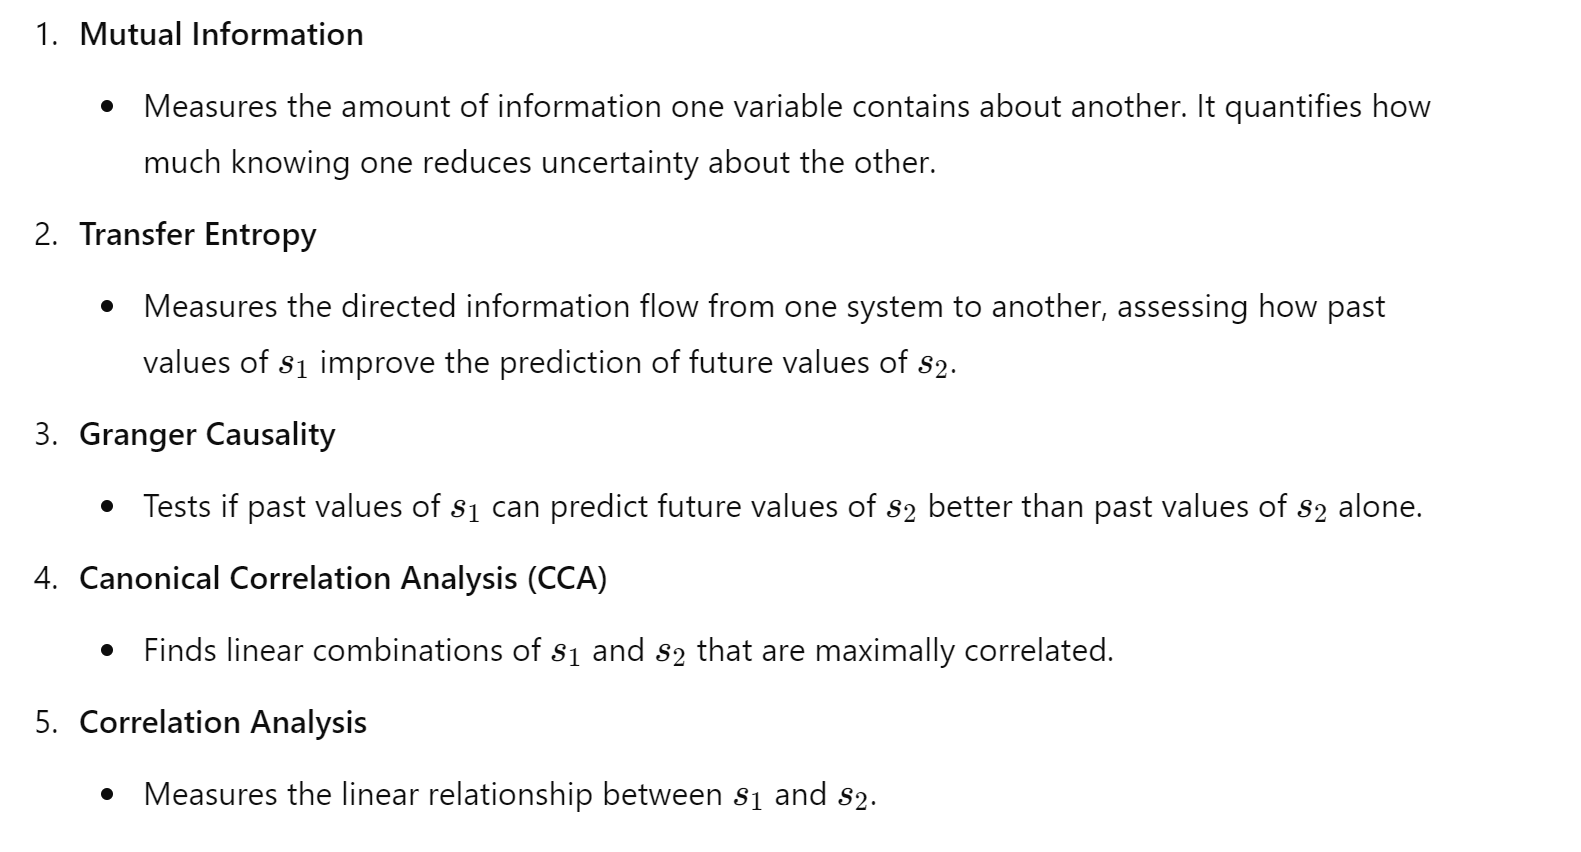

def build_reservior():